# Week 16 - Day 3: Q-Learning for Trading

## Learning Objectives
- Understand Q-tables and the Bellman equation
- Implement Q-learning from scratch
- Build a trading environment with discrete states
- Evaluate agent performance

---

## 1. Introduction to Q-Learning

Q-Learning is a **model-free, off-policy** reinforcement learning algorithm that learns the value of actions in states without requiring a model of the environment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 2. Q-Table and Bellman Equation

### The Q-Function

The **Q-function** (action-value function) represents the expected cumulative reward for taking action $a$ in state $s$ and following the optimal policy thereafter:

$$Q^*(s, a) = \mathbb{E}\left[R_t + \gamma \max_{a'} Q^*(s', a') \mid s_t = s, a_t = a\right]$$

### Bellman Equation

The **Bellman optimality equation** for Q-learning:

$$Q(s, a) \leftarrow Q(s, a) + \alpha \left[r + \gamma \max_{a'} Q(s', a') - Q(s, a)\right]$$

Where:
- $\alpha$ = learning rate (how much to update)
- $\gamma$ = discount factor (importance of future rewards)
- $r$ = immediate reward
- $s'$ = next state
- $a'$ = next action

### Q-Table Structure

A Q-table stores Q-values for all state-action pairs:

| State | Action: Hold | Action: Buy | Action: Sell |
|-------|-------------|-------------|---------------|
| Uptrend | Q(up, hold) | Q(up, buy) | Q(up, sell) |
| Downtrend | Q(down, hold) | Q(down, buy) | Q(down, sell) |
| Sideways | Q(side, hold) | Q(side, buy) | Q(side, sell) |

In [2]:
class QTable:
    """
    Q-Table implementation for storing and updating Q-values.
    """
    
    def __init__(self, n_states, n_actions, learning_rate=0.1, discount_factor=0.95):
        """
        Initialize Q-Table.
        
        Parameters:
        -----------
        n_states : int
            Number of discrete states
        n_actions : int
            Number of possible actions
        learning_rate : float
            Alpha - step size for updates
        discount_factor : float
            Gamma - importance of future rewards
        """
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = learning_rate
        self.gamma = discount_factor
        
        # Initialize Q-table with zeros
        self.q_table = np.zeros((n_states, n_actions))
        
    def get_q_value(self, state, action):
        """Get Q-value for state-action pair."""
        return self.q_table[state, action]
    
    def get_best_action(self, state):
        """Get action with highest Q-value for given state."""
        return np.argmax(self.q_table[state])
    
    def update(self, state, action, reward, next_state):
        """
        Update Q-value using Bellman equation.
        
        Q(s,a) <- Q(s,a) + α[r + γ·max_a'(Q(s',a')) - Q(s,a)]
        """
        current_q = self.q_table[state, action]
        max_next_q = np.max(self.q_table[next_state])
        
        # Bellman equation update
        td_target = reward + self.gamma * max_next_q
        td_error = td_target - current_q
        
        self.q_table[state, action] = current_q + self.alpha * td_error
        
        return td_error
    
    def display(self, state_names=None, action_names=None):
        """Display Q-table with optional labels."""
        if state_names is None:
            state_names = [f"State_{i}" for i in range(self.n_states)]
        if action_names is None:
            action_names = [f"Action_{i}" for i in range(self.n_actions)]
            
        print("\nQ-Table:")
        print("-" * 60)
        header = f"{'State':<15}" + "".join([f"{a:<12}" for a in action_names])
        print(header)
        print("-" * 60)
        
        for i, state_name in enumerate(state_names):
            row = f"{state_name:<15}"
            for j in range(self.n_actions):
                row += f"{self.q_table[i, j]:<12.4f}"
            print(row)

# Demonstrate Q-table
print("=" * 60)
print("Q-Table Demonstration")
print("=" * 60)

# Create simple Q-table: 3 states (trend), 3 actions (hold, buy, sell)
q_table = QTable(n_states=3, n_actions=3, learning_rate=0.1, discount_factor=0.95)

state_names = ["Uptrend", "Downtrend", "Sideways"]
action_names = ["Hold", "Buy", "Sell"]

print("\nInitial Q-Table (all zeros):")
q_table.display(state_names, action_names)

Q-Table Demonstration

Initial Q-Table (all zeros):

Q-Table:
------------------------------------------------------------
State          Hold        Buy         Sell        
------------------------------------------------------------
Uptrend        0.0000      0.0000      0.0000      
Downtrend      0.0000      0.0000      0.0000      
Sideways       0.0000      0.0000      0.0000      


In [3]:
# Demonstrate Bellman equation updates
print("\n" + "=" * 60)
print("Bellman Equation Update Examples")
print("=" * 60)

# Example: Agent in Uptrend (state=0), takes Buy action (action=1)
# Gets reward of +1, transitions to Uptrend (state=0)
print("\nExample 1: Uptrend -> Buy -> Reward +1 -> Uptrend")
print(f"Before: Q(Uptrend, Buy) = {q_table.get_q_value(0, 1):.4f}")

td_error = q_table.update(state=0, action=1, reward=1.0, next_state=0)
print(f"TD Error: {td_error:.4f}")
print(f"After: Q(Uptrend, Buy) = {q_table.get_q_value(0, 1):.4f}")

# More updates to show convergence
print("\nRunning 100 more updates for same transition...")
for _ in range(100):
    q_table.update(state=0, action=1, reward=1.0, next_state=0)
print(f"Q(Uptrend, Buy) converges to: {q_table.get_q_value(0, 1):.4f}")

# Negative example: Downtrend -> Buy -> Loss
print("\nExample 2: Downtrend -> Buy -> Reward -1 -> Downtrend")
for _ in range(100):
    q_table.update(state=1, action=1, reward=-1.0, next_state=1)
print(f"Q(Downtrend, Buy) converges to: {q_table.get_q_value(1, 1):.4f}")

# Positive example: Downtrend -> Sell -> Profit
print("\nExample 3: Downtrend -> Sell -> Reward +1 -> Sideways")
for _ in range(100):
    q_table.update(state=1, action=2, reward=1.0, next_state=2)
print(f"Q(Downtrend, Sell) converges to: {q_table.get_q_value(1, 2):.4f}")

print("\nUpdated Q-Table:")
q_table.display(state_names, action_names)

print("\nBest actions per state:")
for i, state in enumerate(state_names):
    best_action = q_table.get_best_action(i)
    print(f"  {state}: {action_names[best_action]}")


Bellman Equation Update Examples

Example 1: Uptrend -> Buy -> Reward +1 -> Uptrend
Before: Q(Uptrend, Buy) = 0.0000
TD Error: 1.0000
After: Q(Uptrend, Buy) = 0.1000

Running 100 more updates for same transition...
Q(Uptrend, Buy) converges to: 7.9452

Example 2: Downtrend -> Buy -> Reward -1 -> Downtrend
Q(Downtrend, Buy) converges to: -1.0000

Example 3: Downtrend -> Sell -> Reward +1 -> Sideways
Q(Downtrend, Sell) converges to: 1.0000

Updated Q-Table:

Q-Table:
------------------------------------------------------------
State          Hold        Buy         Sell        
------------------------------------------------------------
Uptrend        0.0000      7.9452      0.0000      
Downtrend      0.0000      -1.0000     1.0000      
Sideways       0.0000      0.0000      0.0000      

Best actions per state:
  Uptrend: Buy
  Downtrend: Sell
  Sideways: Hold


## 3. Trading Environment with Discrete States

We'll create a simple trading environment that:
1. Uses synthetic price data
2. Discretizes market conditions into states
3. Provides rewards based on trading P&L

### State Space Design
- **Price Trend**: Up (0), Down (1), Flat (2)
- **Volatility**: Low (0), Medium (1), High (2)
- **Position**: Short (-1), Flat (0), Long (+1)

Total states = 3 × 3 × 3 = 27 states

### Action Space
- **0**: Hold (maintain position)
- **1**: Buy (go long or cover short)
- **2**: Sell (go short or close long)

In [4]:
class TradingEnvironment:
    """
    Simple trading environment with discrete states for Q-learning.
    """
    
    def __init__(self, prices=None, n_steps=1000, transaction_cost=0.001):
        """
        Initialize trading environment.
        
        Parameters:
        -----------
        prices : array-like, optional
            Price series. If None, generates synthetic data.
        n_steps : int
            Number of time steps for synthetic data
        transaction_cost : float
            Cost per trade as fraction of price
        """
        if prices is None:
            self.prices = self._generate_prices(n_steps)
        else:
            self.prices = np.array(prices)
            
        self.n_steps = len(self.prices)
        self.transaction_cost = transaction_cost
        
        # Calculate returns and features
        self.returns = np.diff(self.prices) / self.prices[:-1]
        self.volatility = self._rolling_volatility(window=20)
        
        # State space dimensions
        self.n_trend_states = 3  # Up, Down, Flat
        self.n_vol_states = 3    # Low, Medium, High
        self.n_position_states = 3  # Short, Flat, Long
        self.n_states = self.n_trend_states * self.n_vol_states * self.n_position_states
        
        # Action space
        self.n_actions = 3  # Hold, Buy, Sell
        self.action_names = ['Hold', 'Buy', 'Sell']
        
        self.reset()
        
    def _generate_prices(self, n_steps):
        """Generate synthetic price data with trends and mean reversion."""
        prices = [100.0]
        trend = 0
        
        for i in range(n_steps - 1):
            # Occasionally change trend
            if np.random.random() < 0.05:
                trend = np.random.choice([-0.001, 0, 0.001])
            
            # Random return with trend
            daily_return = trend + np.random.normal(0, 0.02)
            new_price = prices[-1] * (1 + daily_return)
            prices.append(max(new_price, 1))  # Prevent negative prices
            
        return np.array(prices)
    
    def _rolling_volatility(self, window=20):
        """Calculate rolling volatility."""
        vol = np.zeros(len(self.returns))
        for i in range(len(self.returns)):
            start = max(0, i - window + 1)
            vol[i] = np.std(self.returns[start:i+1]) if i > 0 else 0.02
        return vol
    
    def _discretize_trend(self, lookback=5):
        """Discretize price trend into states."""
        if self.current_step < lookback:
            return 2  # Flat
        
        recent_return = (self.prices[self.current_step] - 
                        self.prices[self.current_step - lookback]) / \
                        self.prices[self.current_step - lookback]
        
        if recent_return > 0.01:
            return 0  # Up
        elif recent_return < -0.01:
            return 1  # Down
        else:
            return 2  # Flat
    
    def _discretize_volatility(self):
        """Discretize volatility into states."""
        idx = min(self.current_step - 1, len(self.volatility) - 1)
        if idx < 0:
            return 1  # Medium
            
        vol = self.volatility[idx]
        
        if vol < 0.015:
            return 0  # Low
        elif vol > 0.025:
            return 2  # High
        else:
            return 1  # Medium
    
    def _get_state_index(self):
        """Convert multi-dimensional state to single index."""
        trend = self._discretize_trend()
        vol = self._discretize_volatility()
        pos = self.position + 1  # Convert -1,0,1 to 0,1,2
        
        return trend * 9 + vol * 3 + pos
    
    def reset(self):
        """Reset environment to initial state."""
        self.current_step = 20  # Start after some data for indicators
        self.position = 0  # Flat
        self.entry_price = 0
        self.total_pnl = 0
        self.trade_count = 0
        self.pnl_history = []
        
        return self._get_state_index()
    
    def step(self, action):
        """
        Execute action and return next state, reward, done.
        
        Actions:
        0 = Hold, 1 = Buy, 2 = Sell
        """
        current_price = self.prices[self.current_step]
        reward = 0
        
        # Execute action
        if action == 1:  # Buy
            if self.position <= 0:  # Can buy if flat or short
                if self.position == -1:  # Cover short
                    pnl = (self.entry_price - current_price) / self.entry_price
                    pnl -= self.transaction_cost
                    reward = pnl * 100  # Scale reward
                    self.total_pnl += pnl
                
                self.position = 1
                self.entry_price = current_price
                self.trade_count += 1
                reward -= self.transaction_cost * 10  # Penalize transaction
                
        elif action == 2:  # Sell
            if self.position >= 0:  # Can sell if flat or long
                if self.position == 1:  # Close long
                    pnl = (current_price - self.entry_price) / self.entry_price
                    pnl -= self.transaction_cost
                    reward = pnl * 100  # Scale reward
                    self.total_pnl += pnl
                
                self.position = -1
                self.entry_price = current_price
                self.trade_count += 1
                reward -= self.transaction_cost * 10  # Penalize transaction
        
        # Move to next step
        self.current_step += 1
        self.pnl_history.append(self.total_pnl)
        
        # Check if done
        done = self.current_step >= self.n_steps - 1
        
        # Close any open position at the end
        if done and self.position != 0:
            final_price = self.prices[self.current_step]
            if self.position == 1:
                pnl = (final_price - self.entry_price) / self.entry_price
            else:
                pnl = (self.entry_price - final_price) / self.entry_price
            pnl -= self.transaction_cost
            reward += pnl * 100
            self.total_pnl += pnl
        
        next_state = self._get_state_index()
        
        return next_state, reward, done
    
    def get_info(self):
        """Return current environment information."""
        return {
            'step': self.current_step,
            'price': self.prices[self.current_step],
            'position': self.position,
            'total_pnl': self.total_pnl,
            'trade_count': self.trade_count
        }

# Create and test environment
env = TradingEnvironment(n_steps=1000)

print("=" * 60)
print("Trading Environment Created")
print("=" * 60)
print(f"\nNumber of time steps: {env.n_steps}")
print(f"Number of states: {env.n_states}")
print(f"Number of actions: {env.n_actions}")
print(f"Actions: {env.action_names}")
print(f"Transaction cost: {env.transaction_cost:.2%}")

Trading Environment Created

Number of time steps: 1000
Number of states: 27
Number of actions: 3
Actions: ['Hold', 'Buy', 'Sell']
Transaction cost: 0.10%


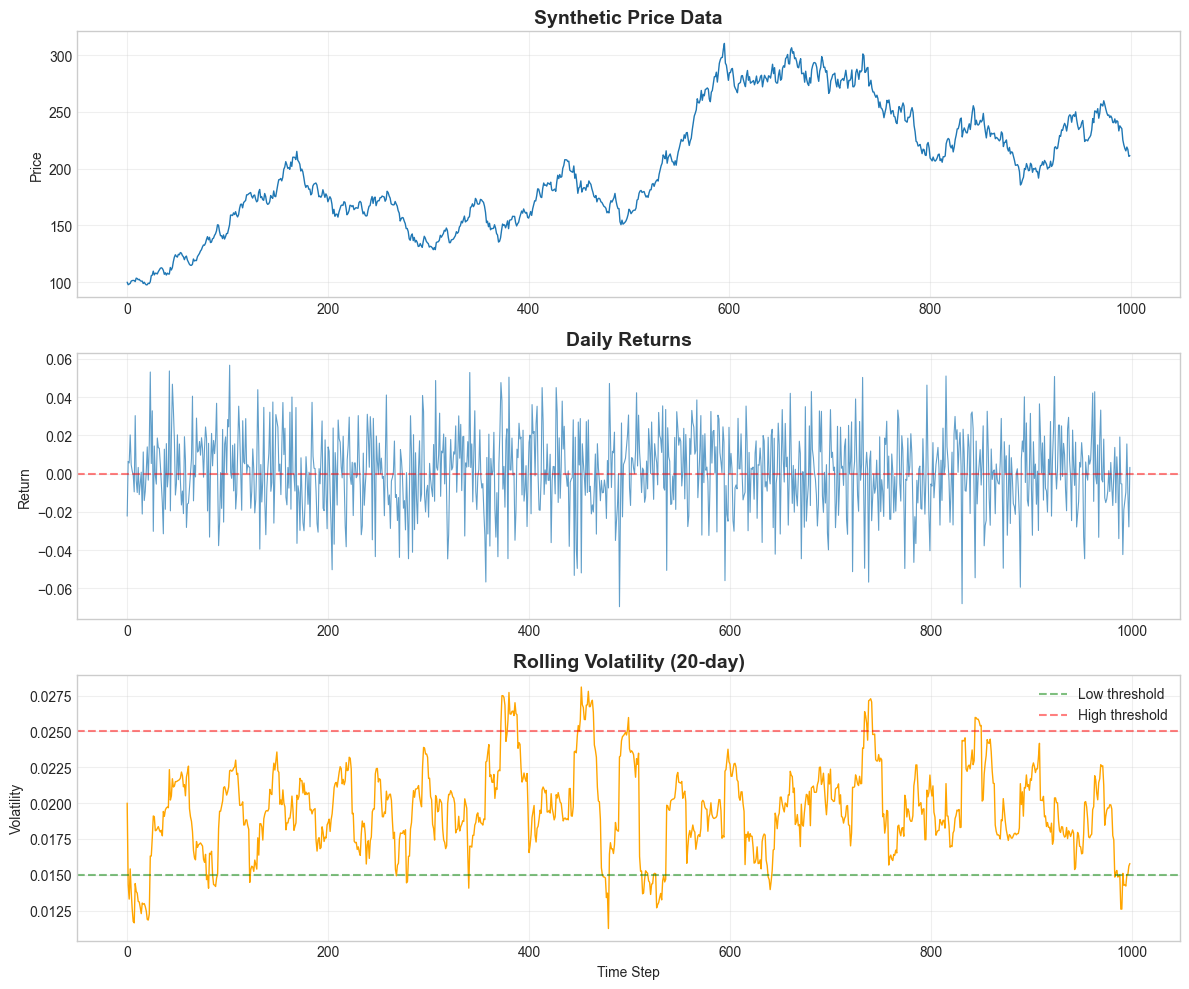


Price Statistics:
  Start: $100.00
  End: $211.56
  Min: $97.64
  Max: $310.40
  Total Return: 111.56%


In [5]:
# Visualize the synthetic price data
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Price
axes[0].plot(env.prices, linewidth=1)
axes[0].set_title('Synthetic Price Data', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price')
axes[0].grid(True, alpha=0.3)

# Returns
axes[1].plot(env.returns, linewidth=0.8, alpha=0.7)
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1].set_title('Daily Returns', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Return')
axes[1].grid(True, alpha=0.3)

# Volatility
axes[2].plot(env.volatility, linewidth=1, color='orange')
axes[2].axhline(y=0.015, color='g', linestyle='--', alpha=0.5, label='Low threshold')
axes[2].axhline(y=0.025, color='r', linestyle='--', alpha=0.5, label='High threshold')
axes[2].set_title('Rolling Volatility (20-day)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Time Step')
axes[2].set_ylabel('Volatility')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPrice Statistics:")
print(f"  Start: ${env.prices[0]:.2f}")
print(f"  End: ${env.prices[-1]:.2f}")
print(f"  Min: ${env.prices.min():.2f}")
print(f"  Max: ${env.prices.max():.2f}")
print(f"  Total Return: {(env.prices[-1]/env.prices[0] - 1)*100:.2f}%")

## 4. Q-Learning Agent Implementation

### Exploration vs Exploitation

We use **ε-greedy** policy:
- With probability ε: explore (random action)
- With probability 1-ε: exploit (best known action)

ε decays over time as the agent learns.

In [6]:
class QLearningAgent:
    """
    Q-Learning agent for trading.
    """
    
    def __init__(self, n_states, n_actions, 
                 learning_rate=0.1, 
                 discount_factor=0.95,
                 epsilon_start=1.0,
                 epsilon_end=0.01,
                 epsilon_decay=0.995):
        """
        Initialize Q-learning agent.
        
        Parameters:
        -----------
        n_states : int
            Number of states
        n_actions : int
            Number of actions
        learning_rate : float
            Learning rate (alpha)
        discount_factor : float
            Discount factor (gamma)
        epsilon_start : float
            Initial exploration rate
        epsilon_end : float
            Minimum exploration rate
        epsilon_decay : float
            Decay rate for epsilon
        """
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = learning_rate
        self.gamma = discount_factor
        
        # Exploration parameters
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
        # Initialize Q-table
        self.q_table = np.zeros((n_states, n_actions))
        
        # Training history
        self.episode_rewards = []
        self.epsilon_history = []
        
    def select_action(self, state, training=True):
        """
        Select action using epsilon-greedy policy.
        """
        if training and np.random.random() < self.epsilon:
            # Explore: random action
            return np.random.randint(self.n_actions)
        else:
            # Exploit: best action
            return np.argmax(self.q_table[state])
    
    def update(self, state, action, reward, next_state):
        """
        Update Q-table using Bellman equation.
        """
        current_q = self.q_table[state, action]
        max_next_q = np.max(self.q_table[next_state])
        
        # Q-learning update
        td_target = reward + self.gamma * max_next_q
        self.q_table[state, action] += self.alpha * (td_target - current_q)
    
    def decay_epsilon(self):
        """Decay exploration rate."""
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
    
    def train_episode(self, env):
        """
        Train for one episode.
        """
        state = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = self.select_action(state, training=True)
            next_state, reward, done = env.step(action)
            
            self.update(state, action, reward, next_state)
            
            state = next_state
            total_reward += reward
        
        self.episode_rewards.append(total_reward)
        self.epsilon_history.append(self.epsilon)
        self.decay_epsilon()
        
        return total_reward, env.total_pnl, env.trade_count
    
    def evaluate(self, env):
        """
        Evaluate agent without exploration.
        """
        state = env.reset()
        total_reward = 0
        done = False
        actions_taken = []
        
        while not done:
            action = self.select_action(state, training=False)
            actions_taken.append(action)
            next_state, reward, done = env.step(action)
            
            state = next_state
            total_reward += reward
        
        return {
            'total_reward': total_reward,
            'total_pnl': env.total_pnl,
            'trade_count': env.trade_count,
            'actions': actions_taken,
            'pnl_history': env.pnl_history
        }

# Create agent
agent = QLearningAgent(
    n_states=env.n_states,
    n_actions=env.n_actions,
    learning_rate=0.1,
    discount_factor=0.95,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.995
)

print("=" * 60)
print("Q-Learning Agent Created")
print("=" * 60)
print(f"\nAgent Parameters:")
print(f"  States: {agent.n_states}")
print(f"  Actions: {agent.n_actions}")
print(f"  Learning Rate (α): {agent.alpha}")
print(f"  Discount Factor (γ): {agent.gamma}")
print(f"  Initial Epsilon: {agent.epsilon}")
print(f"  Final Epsilon: {agent.epsilon_end}")
print(f"  Epsilon Decay: {agent.epsilon_decay}")

Q-Learning Agent Created

Agent Parameters:
  States: 27
  Actions: 3
  Learning Rate (α): 0.1
  Discount Factor (γ): 0.95
  Initial Epsilon: 1.0
  Final Epsilon: 0.01
  Epsilon Decay: 0.995


In [7]:
# Train the agent
print("=" * 60)
print("Training Q-Learning Agent")
print("=" * 60)

n_episodes = 500
pnl_history = []
trade_history = []

for episode in range(n_episodes):
    reward, pnl, trades = agent.train_episode(env)
    pnl_history.append(pnl)
    trade_history.append(trades)
    
    if (episode + 1) % 100 == 0:
        avg_reward = np.mean(agent.episode_rewards[-100:])
        avg_pnl = np.mean(pnl_history[-100:])
        avg_trades = np.mean(trade_history[-100:])
        print(f"Episode {episode+1:4d} | "
              f"Avg Reward: {avg_reward:8.2f} | "
              f"Avg PnL: {avg_pnl*100:6.2f}% | "
              f"Avg Trades: {avg_trades:5.1f} | "
              f"Epsilon: {agent.epsilon:.4f}")

print("\nTraining Complete!")

Training Q-Learning Agent
Episode  100 | Avg Reward:   -61.08 | Avg PnL: -57.81% | Avg Trades: 326.9 | Epsilon: 0.6058
Episode  200 | Avg Reward:   -66.05 | Avg PnL: -63.29% | Avg Trades: 276.8 | Epsilon: 0.3670
Episode  300 | Avg Reward:   -67.85 | Avg PnL: -65.71% | Avg Trades: 213.8 | Epsilon: 0.2223
Episode  400 | Avg Reward:   -69.48 | Avg PnL: -67.97% | Avg Trades: 150.4 | Epsilon: 0.1347
Episode  500 | Avg Reward:   -70.08 | Avg PnL: -69.15% | Avg Trades:  93.6 | Epsilon: 0.0816

Training Complete!


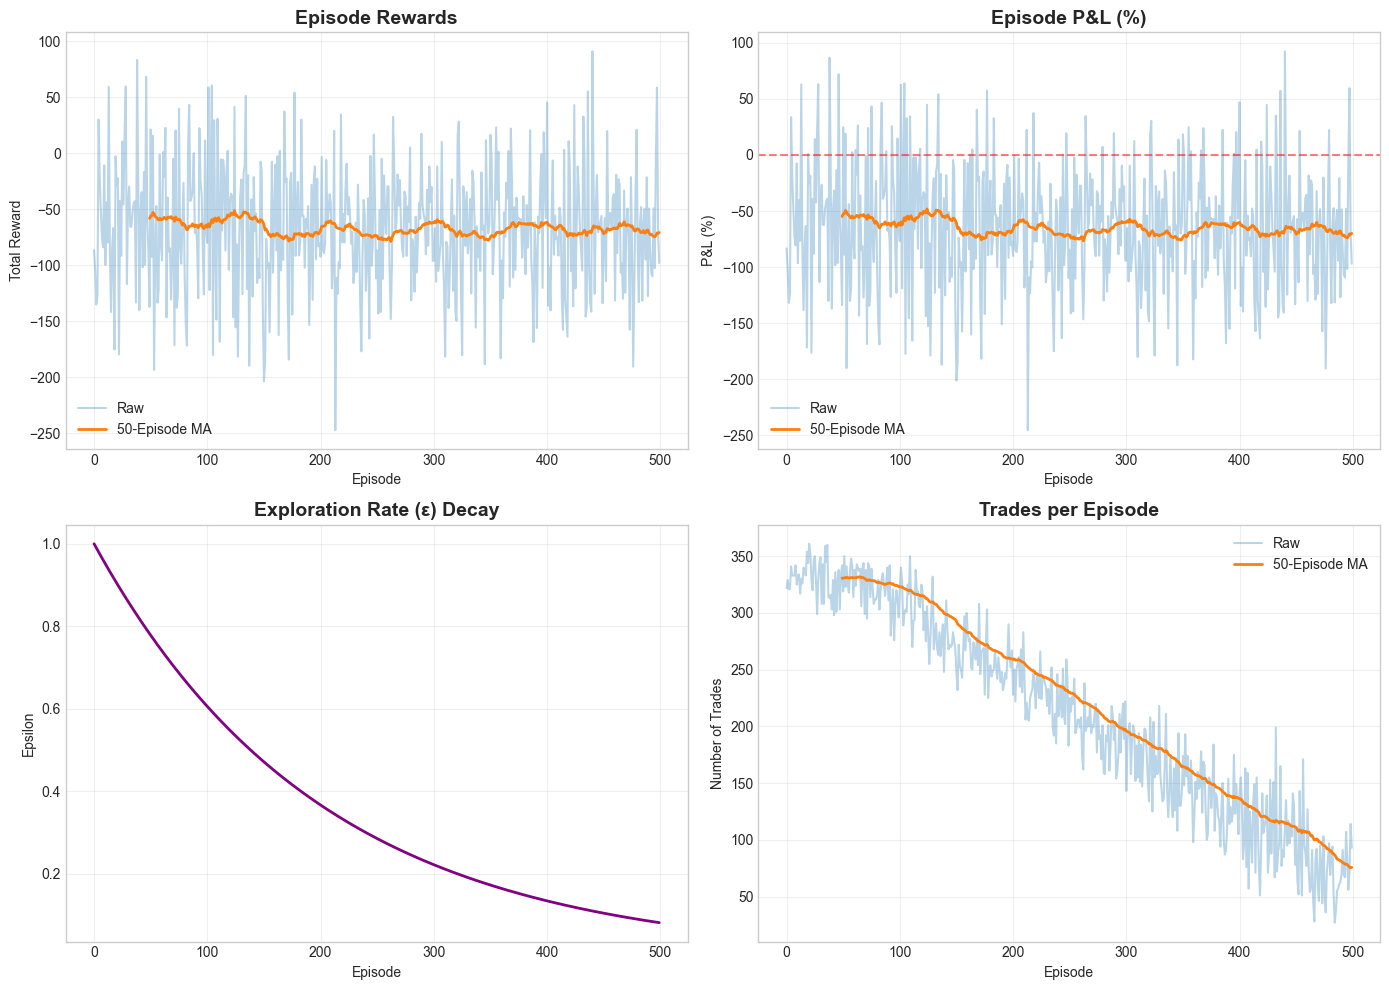

In [8]:
# Visualize training progress
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Episode Rewards
window = 50
rewards_smooth = np.convolve(agent.episode_rewards, 
                             np.ones(window)/window, mode='valid')
axes[0, 0].plot(agent.episode_rewards, alpha=0.3, label='Raw')
axes[0, 0].plot(range(window-1, len(agent.episode_rewards)), 
                rewards_smooth, linewidth=2, label=f'{window}-Episode MA')
axes[0, 0].set_title('Episode Rewards', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Total Reward')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# PnL History
pnl_smooth = np.convolve(np.array(pnl_history)*100, 
                         np.ones(window)/window, mode='valid')
axes[0, 1].plot(np.array(pnl_history)*100, alpha=0.3, label='Raw')
axes[0, 1].plot(range(window-1, len(pnl_history)), 
                pnl_smooth, linewidth=2, label=f'{window}-Episode MA')
axes[0, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 1].set_title('Episode P&L (%)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('P&L (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Epsilon Decay
axes[1, 0].plot(agent.epsilon_history, linewidth=2, color='purple')
axes[1, 0].set_title('Exploration Rate (ε) Decay', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Epsilon')
axes[1, 0].grid(True, alpha=0.3)

# Trade Count
trades_smooth = np.convolve(trade_history, 
                            np.ones(window)/window, mode='valid')
axes[1, 1].plot(trade_history, alpha=0.3, label='Raw')
axes[1, 1].plot(range(window-1, len(trade_history)), 
                trades_smooth, linewidth=2, label=f'{window}-Episode MA')
axes[1, 1].set_title('Trades per Episode', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Number of Trades')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Performance Evaluation

We'll evaluate the trained agent by:
1. Running it on the same environment without exploration
2. Comparing to baseline strategies
3. Analyzing the learned Q-table
4. Computing key performance metrics

In [9]:
# Evaluate trained agent
print("=" * 60)
print("Evaluating Trained Agent")
print("=" * 60)

eval_results = agent.evaluate(env)

print(f"\nAgent Performance:")
print(f"  Total Reward: {eval_results['total_reward']:.2f}")
print(f"  Total P&L: {eval_results['total_pnl']*100:.2f}%")
print(f"  Number of Trades: {eval_results['trade_count']}")

# Action distribution
actions = np.array(eval_results['actions'])
action_counts = [np.sum(actions == i) for i in range(3)]
print(f"\nAction Distribution:")
print(f"  Hold: {action_counts[0]:4d} ({action_counts[0]/len(actions)*100:.1f}%)")
print(f"  Buy:  {action_counts[1]:4d} ({action_counts[1]/len(actions)*100:.1f}%)")
print(f"  Sell: {action_counts[2]:4d} ({action_counts[2]/len(actions)*100:.1f}%)")

Evaluating Trained Agent

Agent Performance:
  Total Reward: 60.02
  Total P&L: 60.29%
  Number of Trades: 27

Action Distribution:
  Hold:   50 (5.1%)
  Buy:   845 (86.3%)
  Sell:   84 (8.6%)


In [10]:
# Compare with baseline strategies
print("\n" + "=" * 60)
print("Baseline Strategy Comparison")
print("=" * 60)

def buy_and_hold(env):
    """Buy and hold strategy."""
    state = env.reset()
    env.step(1)  # Buy at start
    while env.current_step < env.n_steps - 1:
        env.step(0)  # Hold
    return env.total_pnl

def random_strategy(env, n_runs=100):
    """Random action strategy."""
    pnls = []
    for _ in range(n_runs):
        state = env.reset()
        done = False
        while not done:
            action = np.random.randint(3)
            _, _, done = env.step(action)
        pnls.append(env.total_pnl)
    return np.mean(pnls), np.std(pnls)

def momentum_strategy(env, lookback=10):
    """Simple momentum strategy."""
    state = env.reset()
    done = False
    
    while not done:
        if env.current_step >= lookback:
            recent_return = (env.prices[env.current_step] - 
                           env.prices[env.current_step - lookback]) / \
                           env.prices[env.current_step - lookback]
            
            if recent_return > 0.01 and env.position <= 0:
                action = 1  # Buy
            elif recent_return < -0.01 and env.position >= 0:
                action = 2  # Sell
            else:
                action = 0  # Hold
        else:
            action = 0
        
        _, _, done = env.step(action)
    
    return env.total_pnl

# Run baselines
bh_pnl = buy_and_hold(env)
random_pnl_mean, random_pnl_std = random_strategy(env)
momentum_pnl = momentum_strategy(env)
qlearning_pnl = eval_results['total_pnl']

print(f"\nStrategy Results:")
print(f"  {'Strategy':<20} {'P&L':>10} {'vs B&H':>12}")
print(f"  {'-'*20} {'-'*10} {'-'*12}")
print(f"  {'Buy & Hold':<20} {bh_pnl*100:>9.2f}% {'-':>12}")
print(f"  {'Random (avg±std)':<20} {random_pnl_mean*100:>9.2f}% "
      f"{(random_pnl_mean-bh_pnl)*100:>+11.2f}%")
print(f"  {'Momentum':<20} {momentum_pnl*100:>9.2f}% "
      f"{(momentum_pnl-bh_pnl)*100:>+11.2f}%")
print(f"  {'Q-Learning':<20} {qlearning_pnl*100:>9.2f}% "
      f"{(qlearning_pnl-bh_pnl)*100:>+11.2f}%")


Baseline Strategy Comparison

Strategy Results:
  Strategy                    P&L       vs B&H
  -------------------- ---------- ------------
  Buy & Hold              116.28%            -
  Random (avg±std)        -21.79%     -138.07%
  Momentum                 53.54%      -62.74%
  Q-Learning               60.29%      -55.99%



Learned Q-Table Analysis


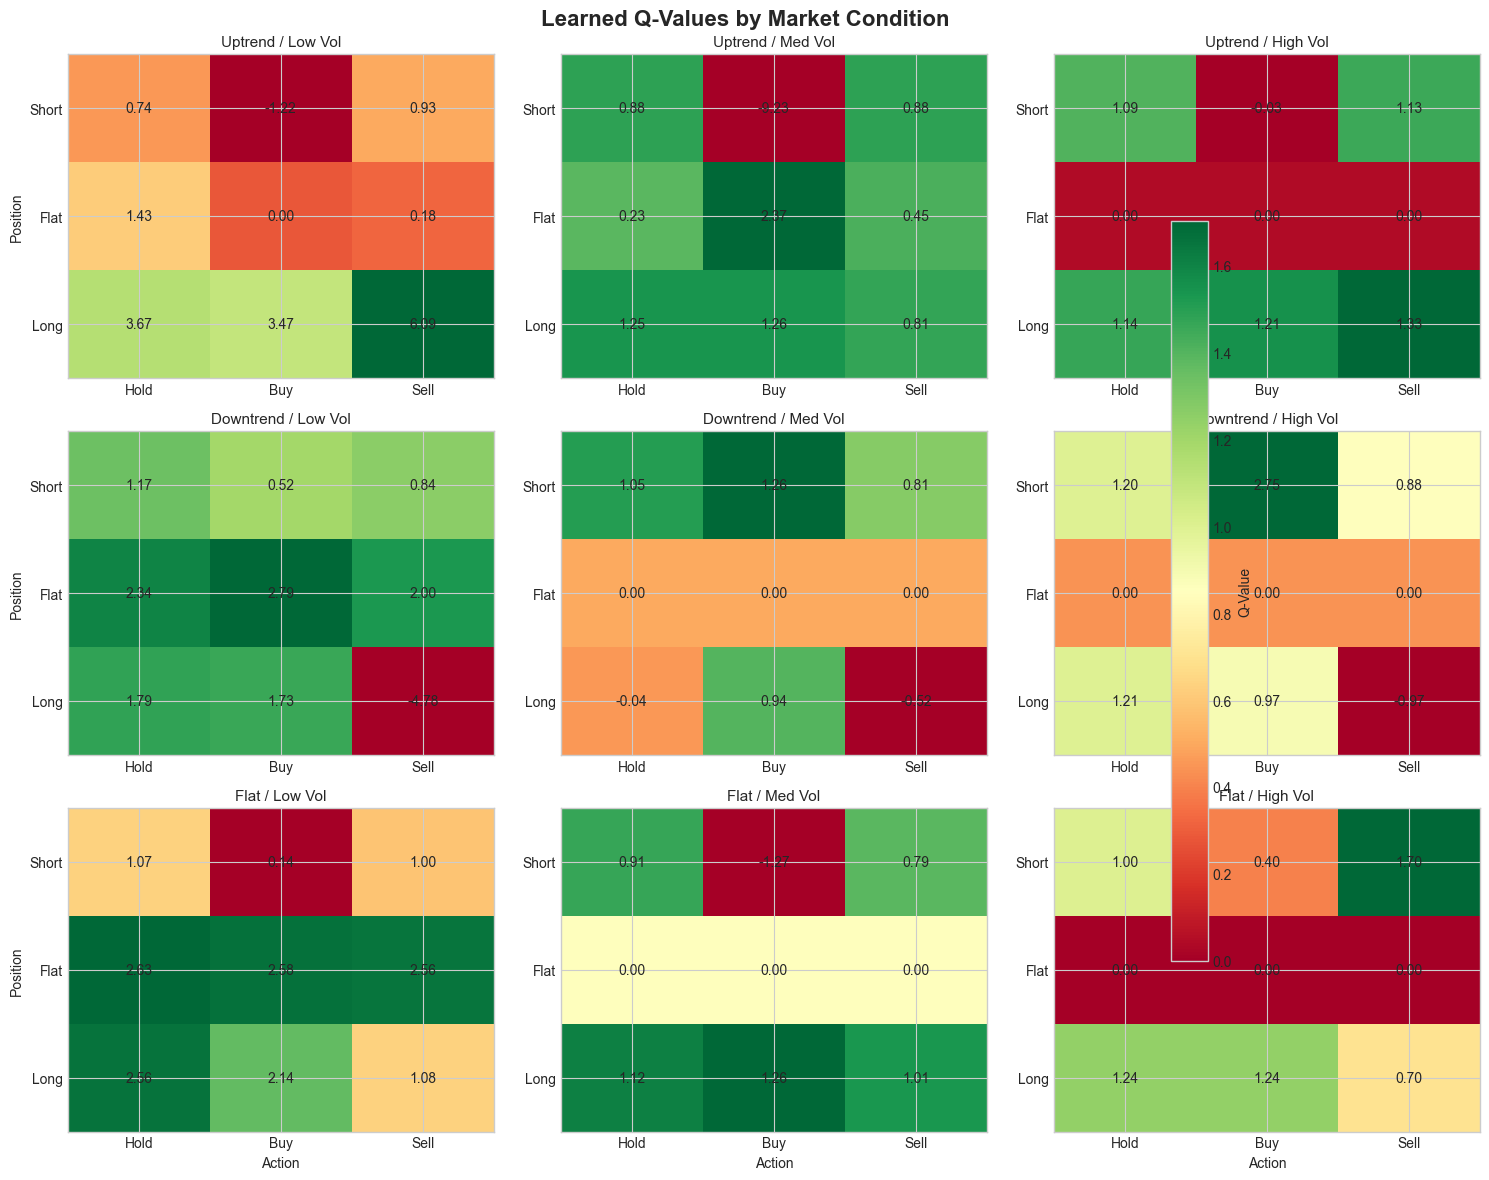


Optimal Policy (Best Action per State):
Trend        Volatility   Position   Best Action 
--------------------------------------------------
Uptrend      Low Vol      Short      Sell        
Uptrend      Low Vol      Flat       Hold        
Uptrend      Low Vol      Long       Sell        
Uptrend      Med Vol      Short      Sell        
Uptrend      Med Vol      Flat       Buy         
Uptrend      Med Vol      Long       Buy         
Uptrend      High Vol     Short      Sell        
Uptrend      High Vol     Flat       Hold        
Uptrend      High Vol     Long       Sell        
Downtrend    Low Vol      Short      Hold        
Downtrend    Low Vol      Flat       Buy         
Downtrend    Low Vol      Long       Hold        
Downtrend    Med Vol      Short      Buy         
Downtrend    Med Vol      Flat       Hold        
Downtrend    Med Vol      Long       Buy         
Downtrend    High Vol     Short      Buy         
Downtrend    High Vol     Flat       Hold        
Downtren

In [11]:
# Visualize Q-table
print("\n" + "=" * 60)
print("Learned Q-Table Analysis")
print("=" * 60)

# Reshape Q-table for visualization
# State encoding: trend(0-2) * 9 + vol(0-2) * 3 + pos(0-2)
trend_names = ['Uptrend', 'Downtrend', 'Flat']
vol_names = ['Low Vol', 'Med Vol', 'High Vol']
pos_names = ['Short', 'Flat', 'Long']
action_names = ['Hold', 'Buy', 'Sell']

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Learned Q-Values by Market Condition', fontsize=16, fontweight='bold')

for trend in range(3):
    for vol in range(3):
        ax = axes[trend, vol]
        
        # Extract Q-values for this trend/vol combination
        q_values = np.zeros((3, 3))  # Position x Action
        for pos in range(3):
            state_idx = trend * 9 + vol * 3 + pos
            q_values[pos] = agent.q_table[state_idx]
        
        im = ax.imshow(q_values, cmap='RdYlGn', aspect='auto')
        
        # Add text annotations
        for i in range(3):
            for j in range(3):
                text = ax.text(j, i, f'{q_values[i, j]:.2f}',
                             ha='center', va='center', fontsize=10)
        
        ax.set_xticks(range(3))
        ax.set_yticks(range(3))
        ax.set_xticklabels(action_names)
        ax.set_yticklabels(pos_names)
        ax.set_title(f'{trend_names[trend]} / {vol_names[vol]}', fontsize=11)
        
        if vol == 0:
            ax.set_ylabel('Position')
        if trend == 2:
            ax.set_xlabel('Action')

plt.colorbar(im, ax=axes, label='Q-Value', shrink=0.8)
plt.tight_layout()
plt.show()

# Optimal policy extraction
print("\nOptimal Policy (Best Action per State):")
print(f"{'Trend':<12} {'Volatility':<12} {'Position':<10} {'Best Action':<12}")
print("-" * 50)

for trend in range(3):
    for vol in range(3):
        for pos in range(3):
            state_idx = trend * 9 + vol * 3 + pos
            best_action = np.argmax(agent.q_table[state_idx])
            print(f"{trend_names[trend]:<12} {vol_names[vol]:<12} "
                  f"{pos_names[pos]:<10} {action_names[best_action]:<12}")

In [12]:
# Performance metrics
print("\n" + "=" * 60)
print("Detailed Performance Metrics")
print("=" * 60)

def calculate_metrics(pnl_history, prices, n_trades):
    """Calculate performance metrics."""
    pnl_array = np.array(pnl_history)
    returns = np.diff(pnl_array)
    returns = returns[returns != 0]  # Remove zeros
    
    if len(returns) == 0:
        return {}
    
    metrics = {}
    metrics['total_return'] = pnl_array[-1] if len(pnl_array) > 0 else 0
    metrics['n_trades'] = n_trades
    
    # Annualized metrics (assuming 252 trading days)
    n_periods = len(prices) - 20  # Trading periods
    annual_factor = 252 / n_periods
    
    metrics['annualized_return'] = metrics['total_return'] * annual_factor
    
    # Volatility
    if len(returns) > 1:
        metrics['volatility'] = np.std(returns) * np.sqrt(252)
        metrics['sharpe_ratio'] = (metrics['annualized_return'] / 
                                   metrics['volatility']) if metrics['volatility'] > 0 else 0
    else:
        metrics['volatility'] = 0
        metrics['sharpe_ratio'] = 0
    
    # Win rate
    if len(returns) > 0:
        wins = np.sum(returns > 0)
        metrics['win_rate'] = wins / len(returns)
    else:
        metrics['win_rate'] = 0
    
    # Max drawdown
    cumulative = np.cumsum(np.concatenate([[0], returns]))
    running_max = np.maximum.accumulate(cumulative)
    drawdown = running_max - cumulative
    metrics['max_drawdown'] = np.max(drawdown)
    
    return metrics

metrics = calculate_metrics(eval_results['pnl_history'], env.prices, 
                           eval_results['trade_count'])

print(f"\nPerformance Summary:")
print(f"  Total Return:      {metrics.get('total_return', 0)*100:>8.2f}%")
print(f"  Annualized Return: {metrics.get('annualized_return', 0)*100:>8.2f}%")
print(f"  Volatility (Ann.): {metrics.get('volatility', 0)*100:>8.2f}%")
print(f"  Sharpe Ratio:      {metrics.get('sharpe_ratio', 0):>8.2f}")
print(f"  Win Rate:          {metrics.get('win_rate', 0)*100:>8.2f}%")
print(f"  Max Drawdown:      {metrics.get('max_drawdown', 0)*100:>8.2f}%")
print(f"  Number of Trades:  {metrics.get('n_trades', 0):>8d}")


Detailed Performance Metrics

Performance Summary:
  Total Return:         69.53%
  Annualized Return:    17.88%
  Volatility (Ann.):   201.00%
  Sharpe Ratio:          0.09
  Win Rate:             69.23%
  Max Drawdown:         34.63%
  Number of Trades:        27


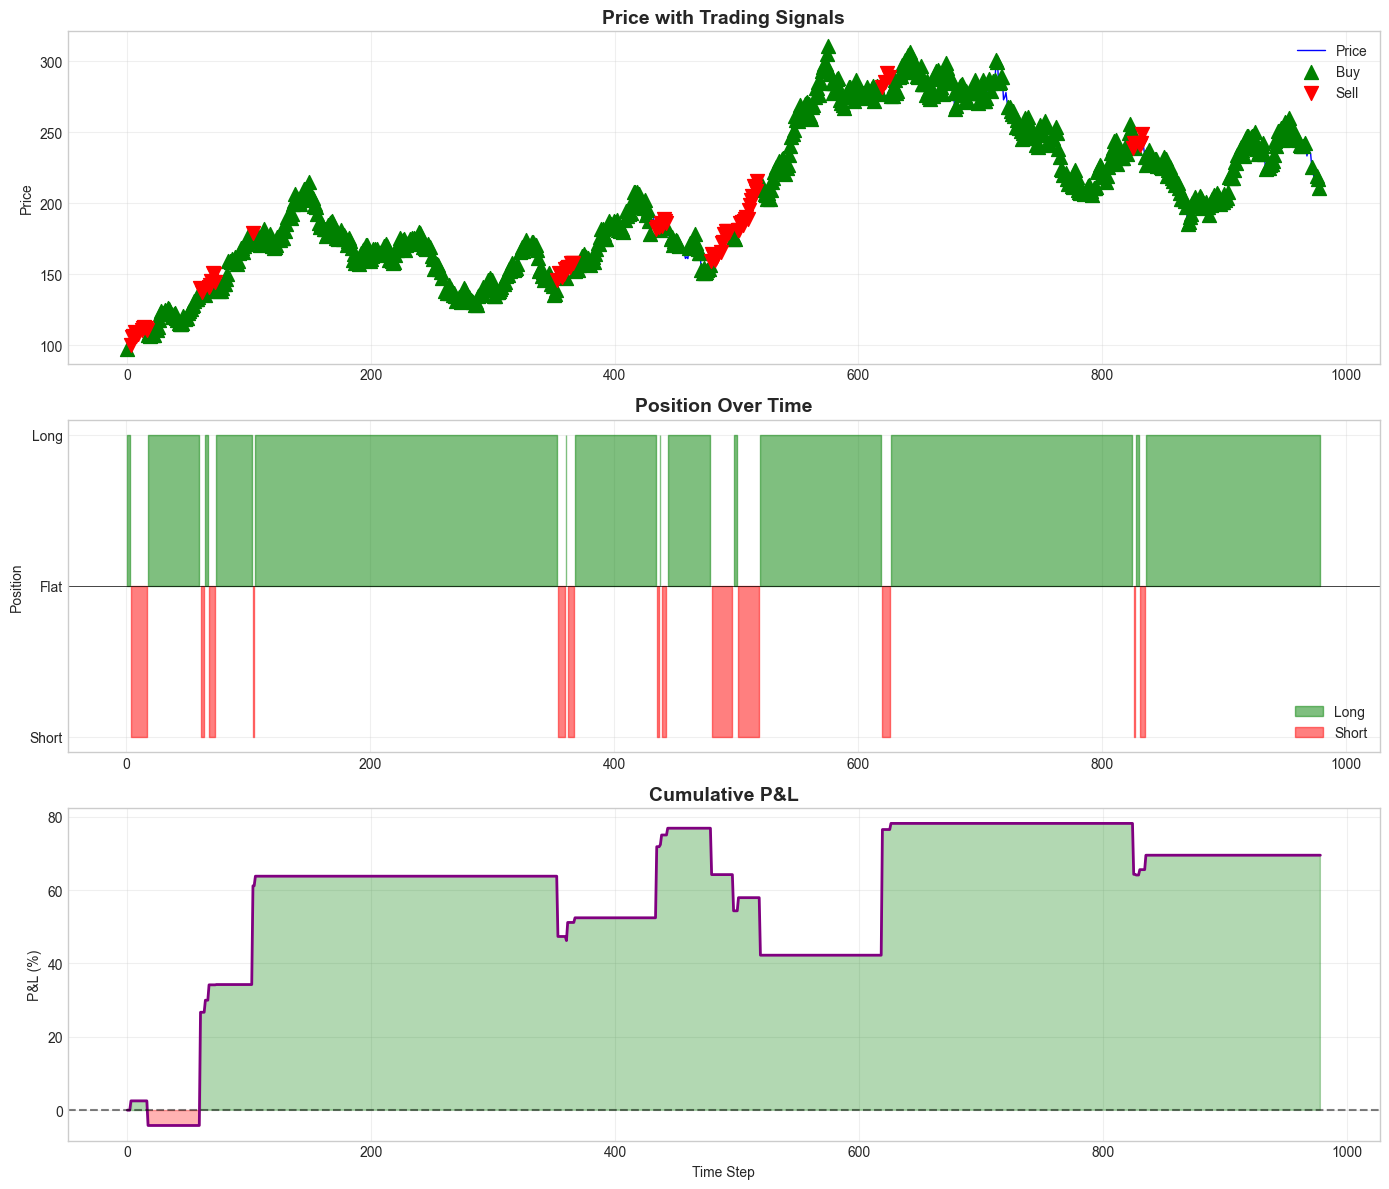

In [13]:
# Visualize agent's trading behavior
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Re-run evaluation to get detailed data
state = env.reset()
positions = [0]
actions_taken = []
prices_during_trade = [env.prices[env.current_step]]

done = False
while not done:
    action = agent.select_action(state, training=False)
    actions_taken.append(action)
    next_state, _, done = env.step(action)
    positions.append(env.position)
    prices_during_trade.append(env.prices[min(env.current_step, len(env.prices)-1)])
    state = next_state

# Plot 1: Price with buy/sell signals
ax1 = axes[0]
ax1.plot(prices_during_trade, linewidth=1, label='Price', color='blue')

# Mark buy/sell actions
buy_idx = [i for i, a in enumerate(actions_taken) if a == 1]
sell_idx = [i for i, a in enumerate(actions_taken) if a == 2]

if buy_idx:
    ax1.scatter(buy_idx, [prices_during_trade[i] for i in buy_idx], 
               marker='^', color='green', s=100, label='Buy', zorder=5)
if sell_idx:
    ax1.scatter(sell_idx, [prices_during_trade[i] for i in sell_idx], 
               marker='v', color='red', s=100, label='Sell', zorder=5)

ax1.set_title('Price with Trading Signals', fontsize=14, fontweight='bold')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Position over time
ax2 = axes[1]
ax2.fill_between(range(len(positions)), positions, 0, 
                 where=np.array(positions) > 0, alpha=0.5, color='green', label='Long')
ax2.fill_between(range(len(positions)), positions, 0, 
                 where=np.array(positions) < 0, alpha=0.5, color='red', label='Short')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_title('Position Over Time', fontsize=14, fontweight='bold')
ax2.set_ylabel('Position')
ax2.set_yticks([-1, 0, 1])
ax2.set_yticklabels(['Short', 'Flat', 'Long'])
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Cumulative PnL
ax3 = axes[2]
pnl_curve = np.array(eval_results['pnl_history']) * 100
ax3.plot(pnl_curve, linewidth=2, color='purple')
ax3.fill_between(range(len(pnl_curve)), pnl_curve, 0, 
                 where=pnl_curve > 0, alpha=0.3, color='green')
ax3.fill_between(range(len(pnl_curve)), pnl_curve, 0, 
                 where=pnl_curve < 0, alpha=0.3, color='red')
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax3.set_title('Cumulative P&L', fontsize=14, fontweight='bold')
ax3.set_xlabel('Time Step')
ax3.set_ylabel('P&L (%)')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Summary and Key Takeaways

### What We Learned

1. **Q-Table Basics**
   - Q-values represent expected future rewards for state-action pairs
   - The Bellman equation provides the recursive update rule
   - Q-tables store values for all discrete states and actions

2. **Q-Learning Algorithm**
   - Model-free: learns from experience without environment model
   - Off-policy: can learn from exploratory actions
   - Uses ε-greedy for exploration-exploitation balance

3. **Trading Environment Design**
   - State discretization: trend, volatility, position
   - Action space: hold, buy, sell
   - Reward function: P&L with transaction costs

4. **Performance Evaluation**
   - Compare against baseline strategies
   - Analyze learned policy through Q-table
   - Track multiple metrics (Sharpe, drawdown, win rate)

### Limitations of Tabular Q-Learning

- **State space explosion**: Continuous features need discretization
- **Memory requirements**: Q-table grows with states × actions
- **Generalization**: Cannot generalize to unseen states

### Next Steps

- **Day 4**: Deep Q-Networks (DQN) for continuous state spaces
- **Day 5**: Policy gradient methods
- **Day 6**: Actor-Critic algorithms

In [14]:
# Final summary
print("=" * 60)
print("Week 16 Day 3 - Q-Learning Summary")
print("=" * 60)

print("\n✓ Concepts Covered:")
print("  • Q-Table structure and initialization")
print("  • Bellman equation for value updates")
print("  • Epsilon-greedy exploration strategy")
print("  • Trading environment with discrete states")
print("  • Performance evaluation and comparison")

print("\n✓ Key Parameters:")
print(f"  • Learning Rate (α): {agent.alpha}")
print(f"  • Discount Factor (γ): {agent.gamma}")
print(f"  • Epsilon Decay: {agent.epsilon_decay}")
print(f"  • Episodes Trained: {n_episodes}")

print("\n✓ Results:")
print(f"  • Final P&L: {eval_results['total_pnl']*100:.2f}%")
print(f"  • Trades Executed: {eval_results['trade_count']}")
print(f"  • Win Rate: {metrics.get('win_rate', 0)*100:.1f}%")

print("\n" + "=" * 60)
print("Notebook completed successfully!")
print("=" * 60)

Week 16 Day 3 - Q-Learning Summary

✓ Concepts Covered:
  • Q-Table structure and initialization
  • Bellman equation for value updates
  • Epsilon-greedy exploration strategy
  • Trading environment with discrete states
  • Performance evaluation and comparison

✓ Key Parameters:
  • Learning Rate (α): 0.1
  • Discount Factor (γ): 0.95
  • Epsilon Decay: 0.995
  • Episodes Trained: 500

✓ Results:
  • Final P&L: 60.29%
  • Trades Executed: 27
  • Win Rate: 69.2%

Notebook completed successfully!
